In [43]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import json
import networkx as nx # network analysis
from networkx.readwrite import json_graph
import itertools
import os.path
from datetime import datetime # for time measurement
import sys
import os
import pickle
import subprocess as subp
import gzip
import math
import codecs

from jellyfish import jaro_distance, jaro_winkler, hamming_distance, levenshtein_distance
import scipy.cluster.hierarchy as scipycluster
from sklearn.feature_extraction.text import TfidfVectorizer

from skimage import io, exposure
from scipy.spatial import distance
# import the k-means algorithm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin,pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances



# image handling
from PIL import Image

# geo stuff
from geopy.distance import vincenty
import geojson as gj

import csv

def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def pickleCompress(fileName,pickledObject):
    printLog("Pickling to '%s'" %fileName)
    f = gzip.open(fileName,'wb')
    pickle.dump(pickledObject,f)
    f.close()
    printLog("Pickling done.")
    
def pickleDecompress(fileName):
    #restore the object
    printLog("Depickling from '%s'" %fileName)
    f = gzip.open(fileName,'rb')
    pickledObject = pickle.load(f)
    f.close()
    printLog("Depickling done.")
    return pickledObject

if not os.path.exists("./analysis/"):
        os.makedirs("./analysis/")


In [44]:
def createGraph(data):
    # create an empty graph from the nx (networkx) package imported above
    G=nx.DiGraph()

    rowCount=0
    seenAuthors=[]
    seenLocations=[]
    seenPublishers=[]
    #noRecords=len(data.keys())
    #print("Processing %i records."%noRecords)
    for ppn in data:
        #print(ppn)
        rowCount=rowCount+1
        #if rowCount%10000==0:
        #    printLog("Processed %i records of %i"%(rowCount,noRecords))
        
        
        author=data[ppn]["author"]
        authorID=data[ppn]["authorID"]
        publisher=data[ppn]["publisher"]
        publisherLocation=data[ppn]["publisherLocation"]
        
        title=data[ppn]["title"]
        
        if author:
            if not author in seenAuthors:
                seenAuthors.append(author)
                G.add_node(author)
                # the name attribute will be helpful for D3.js visualizations
                G.node[author]['name'] = author
                G.node[author]['type'] = "author"
                if authorID:
                    G.node[author]['id'] = authorID
        if publisher:
            if not publisher in seenPublishers:
                seenPublishers.append(publisher)
                G.add_node(publisher)
                G.node[publisher]['name'] = publisher
                G.node[publisher]['type'] = "publisher"
       
        if publisherLocation:
            if not publisherLocation in seenLocations:
                seenLocations.append(publisherLocation)
                G.add_node(publisherLocation)
                G.node[publisherLocation]['name'] = publisherLocation
                G.node[publisherLocation]['type'] = "publisherLocation"
        
        if title:
            G.add_node(title)
            G.node[title]['name'] = title
            G.node[title]['type'] = "title"
        
        if author and title:
            G.add_edge(author,title)
        if publisher and title:
            G.add_edge(publisher,title)
            
        if author and publisher:
            G.add_edge(author,publisher)
        if publisher and publisherLocation:
            G.add_edge(publisher,publisherLocation)
        
    return G

In [45]:
def createGraph_Author_Publisher_Location(data):
    # create an empty graph from the nx (networkx) package imported above
    G=nx.DiGraph()

    rowCount=0
    seenAuthors=[]
    seenLocations=[]
    seenPublishers=[]
    #noRecords=len(data.keys())
    #print("Processing %i records."%noRecords)
    for ppn in data:
        #print(ppn)
        rowCount=rowCount+1
        #if rowCount%10000==0:
        #    printLog("Processed %i records of %i"%(rowCount,noRecords))
        
        author=data[ppn]["author"]
        authorID=data[ppn]["authorID"]
        publisher=data[ppn]["publisher"]
        publisherLocation=data[ppn]["publisherLocation"]
        
        title=data[ppn]["title"]
        
        if author:
            if not author in seenAuthors:
                seenAuthors.append(author)
                G.add_node(author)
                # the name attribute will be helpful for D3.js visualizations
                G.node[author]['name'] = author
                G.node[author]['type'] = "author"
                if authorID:
                    G.node[author]['id'] = authorID
        if publisher:
            if not publisher in seenPublishers:
                seenPublishers.append(publisher)
                G.add_node(publisher)
                G.node[publisher]['name'] = publisher
                G.node[publisher]['type'] = "publisher"
       
        if publisherLocation:
            if not publisherLocation in seenLocations:
                seenLocations.append(publisherLocation)
                G.add_node(publisherLocation)
                G.node[publisherLocation]['name'] = publisherLocation
                G.node[publisherLocation]['type'] = "publisherLocation"
            
        if author and publisher:
            G.add_edge(author,publisher)
        if publisher and publisherLocation:
            G.add_edge(publisher,publisherLocation)
        
    return G

In [123]:
baseDir="/Users/david/src/__datasets/cbs_analysis/"
# the following catalog files are sorted by file size
files=["fry_out.txt","ice_out.txt","por_out.txt","nor_out.txt","dan_out.txt","swe_out.txt","spa_out.txt","dut_out.txt","ita_out.txt","lat_out.txt","fre_out.txt","eng_out.txt","ger_out.txt"]

# create a dictionary for the records
records=dict()

dataFrameDict={"language":[],"graph_type":[],"nodes":[],"edges":[],"creation_duration":[],"records":[]}

# as we have to deal with very large fields, increase the CSV limit
csv.field_size_limit(sys.maxsize)

# a list containing all read data
allRecords=dict()

for file in files:
    records=dict()
    currentLanguage=file.split("_")[0]
    ppn=None
    with open(baseDir+file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t')
        for row in spamreader:
            # skip empty separator line
            if row:
                # if we haven't seen a PPN before, it is a new record we have to deal with
                if not ppn:
                    ppn=row[0]
                    # an empty dict (with pre-defined language) for the record values
                    values={"title":None,"author":None,"authorID":None,"publisher":None,"publisherLocation":None,"language":currentLanguage}
                    records[ppn]=values
                # check if we deal with a row containing a title
                if row[1]=="021A":
                    records[ppn]["title"]=row[2]
                # publisher
                if row[1]=="033A":
                    tokens=row[2].split("@")
                    if len(tokens)>=2:
                        records[ppn]["publisher"]=tokens[0]
                        records[ppn]["publisherLocation"]=tokens[1].replace("[","").replace("]","")
                    else:
                        records[ppn]["publisher"]=row[2]
                # author
                if row[1]=="028A":
                    tokens=row[2].split("@")
                    if len(tokens)>=2:
                        records[ppn]["author"]=tokens[0]
                        records[ppn]["authorID"]=tokens[1]
                    else:
                        records[ppn]["author"]=row[2]             
            # in case of an empty line, prepare for a new record
            else:
                if ppn:
                    allRecords[ppn]=records[ppn]
                #debug
                #if ppn:
                #    print(ppn+str(records[ppn]))
                ppn=None
    
    
    # * * * * * * * * * * * * * * *
    # process the found records
    # * * * * * * * * * * * * * * *
    noRecords=len(records.keys())
    
    dataFrameDict["language"].append(currentLanguage)
    dataFrameDict["graph_type"].append("author_publisher_location")
    printLog("Processing catalog language: %s"%currentLanguage)
    printLog("Creating graph...")
    startTime = datetime.now()
    returnedGraph=createGraph_Author_Publisher_Location(records)
    endTime = datetime.now()
    dataFrameDict["nodes"].append(len(returnedGraph.nodes()))
    dataFrameDict["edges"].append(len(returnedGraph.edges()))
    dataFrameDict["records"].append(noRecords)
    dataFrameDict["creation_duration"].append(endTime-startTime)
    #printLog("Serializing graph with %i nodes and %i edges."%(len(returnedGraph.nodes()),len(returnedGraph.edges())))
    nx.write_gml(returnedGraph,"analysis/"+currentLanguage+"_author_publisher_location.gml")
    jsonData = json_graph.node_link_data(returnedGraph, {'link': 'edges', 'source': 'from', 'target': 'to'})
    with open("analysis/"+currentLanguage+"_author_publisher_location.json", "w") as write_file:
        json.dump(jsonData, write_file,default={'link': 'edges', 'source': 'from', 'target': 'to'})
    nx.write_graphml(returnedGraph, "analysis/"+currentLanguage+"_author_publisher_location.graphml")
    
    dataFrameDict["language"].append(currentLanguage)
    dataFrameDict["graph_type"].append("author_publisher_location_title")
    printLog("Processing catalog language: %s"%currentLanguage)
    printLog("Creating graph...")
    startTime = datetime.now()
    returnedGraph=createGraph(records)
    endTime = datetime.now()
    dataFrameDict["nodes"].append(len(returnedGraph.nodes()))
    dataFrameDict["edges"].append(len(returnedGraph.edges()))
    dataFrameDict["records"].append(noRecords)
    dataFrameDict["creation_duration"].append(endTime-startTime)
    #printLog("Serializing graph with %i nodes and %i edges."%(len(returnedGraph.nodes()),len(returnedGraph.edges())))
    nx.write_gml(returnedGraph,"analysis/"+currentLanguage+"_author_publisher_location_title.gml")
    jsonData = json_graph.node_link_data(returnedGraph, {'link': 'edges', 'source': 'from', 'target': 'to'})
    with open("analysis/"+currentLanguage+"_author_publisher_location_title.json", "w") as write_file:
        json.dump(jsonData, write_file,default={'link': 'edges', 'source': 'from', 'target': 'to'})
    nx.write_graphml(returnedGraph, "analysis/"+currentLanguage+"_author_publisher_location_title.graphml")
    

    
printLog("\nDone.")

[2019-03-06 20:22:17.060139]	Processing catalog language: fry
[2019-03-06 20:22:17.060970]	Creating graph...
[2019-03-06 20:22:17.393697]	Processing catalog language: fry
[2019-03-06 20:22:17.394490]	Creating graph...
[2019-03-06 20:22:17.447326]	Processing catalog language: ice
[2019-03-06 20:22:17.447865]	Creating graph...
[2019-03-06 20:22:17.482392]	Processing catalog language: ice
[2019-03-06 20:22:17.483218]	Creating graph...
[2019-03-06 20:22:17.633294]	Processing catalog language: por
[2019-03-06 20:22:17.633810]	Creating graph...
[2019-03-06 20:22:18.094311]	Processing catalog language: por
[2019-03-06 20:22:18.094971]	Creating graph...
[2019-03-06 20:22:19.126431]	Processing catalog language: nor
[2019-03-06 20:22:19.126942]	Creating graph...
[2019-03-06 20:22:19.656357]	Processing catalog language: nor
[2019-03-06 20:22:19.656862]	Creating graph...
[2019-03-06 20:22:20.977564]	Processing catalog language: dan
[2019-03-06 20:22:20.978022]	Creating graph...
[2019-03-06 20:22:2

In [124]:
df = pd.DataFrame(dataFrameDict)
df

,language,graph_type,nodes,edges,creation_duration,records
0,fry,author_publisher_location,298,264,00:00:00.207634,360
1,fry,author_publisher_location_title,622,726,00:00:00.003601,360
2,ice,author_publisher_location,505,448,00:00:00.004354,1200
3,ice,author_publisher_location_title,1509,1393,00:00:00.008653,1200
4,por,author_publisher_location,5217,5392,00:00:00.161633,8937
5,por,author_publisher_location_title,12848,15219,00:00:00.188264,8937
6,nor,author_publisher_location,4948,6049,00:00:00.238340,12016
7,nor,author_publisher_location_title,15276,21737,00:00:00.227748,12016
8,dan,author_publisher_location,9127,11711,00:00:00.546869,20089
9,dan,author_publisher_location_title,26144,39278,00:00:00.685729,20089


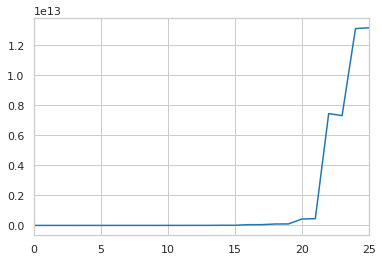

In [125]:
df.creation_duration.plot()

In [126]:
df.to_csv("social_analysis_statistics.csv",index=False)

In [127]:
def createGraph_Language_LinksGraph(data):
    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenAuthors=[]
    seenLanguages=[]
    seenPublishers=[]
    noRecords=len(data.keys())
    #print("Processing %i records."%noRecords)
    for ppn in data:
        #print(ppn)
        rowCount=rowCount+1
        if (rowCount%100000==0) and noRecords>100000:
            printLog("Processed %i records of %i"%(rowCount,noRecords))
        
        author=data[ppn]["author"]
        authorID=data[ppn]["authorID"]
        publisher=data[ppn]["publisher"]
        language=data[ppn]["language"]
        
        if not language in seenLanguages:
            G.add_node(language)
            G.node[language]['type']="language"
            seenLanguages.append(language)
        
        if author:
            if not author in seenAuthors:
                seenAuthors.append(author)
                G.add_node(author)
                # the name attribute will be helpful for D3.js visualizations
                G.node[author]['name'] = author
                G.node[author]['type'] = "author"
                if authorID:
                    G.node[author]['id'] = authorID
            G.add_edge(author,language)
            
        if publisher:
            if not publisher in seenPublishers:
                seenPublishers.append(publisher)
                G.add_node(publisher)
                G.node[publisher]['name'] = publisher
                G.node[publisher]['type'] = "publisher"
            G.add_edge(publisher,language)
            
    return G

In [129]:
dataFrameDict["language"].append("n/a")
dataFrameDict["graph_type"].append("languageLink")
printLog("Processing language link graph.")
printLog("Creating graph...")
startTime = datetime.now()
returnedGraph=createGraph_Language_LinksGraph(allRecords)
endTime = datetime.now()
dataFrameDict["nodes"].append(len(returnedGraph.nodes()))
dataFrameDict["edges"].append(len(returnedGraph.edges()))
dataFrameDict["records"].append(len(allRecords))
dataFrameDict["creation_duration"].append(endTime-startTime)
nx.write_gml(returnedGraph,"analysis/languageLink.gml")
jsonData = json_graph.node_link_data(returnedGraph, {'link': 'edges', 'source': 'from', 'target': 'to'})
with open("analysis/languageLink.json", "w") as write_file:
    json.dump(jsonData, write_file,default={'link': 'edges', 'source': 'from', 'target': 'to'})
nx.write_graphml(returnedGraph, "analysis/languageLink.graphml")
printLog("Done.")

[2019-03-07 09:43:28.304365]	Processing language link graph.
[2019-03-07 09:43:28.305466]	Creating graph...
[2019-03-07 09:43:28.497207]	Processed 10000 records of 4578537
[2019-03-07 09:43:29.035297]	Processed 20000 records of 4578537
[2019-03-07 09:43:29.870406]	Processed 30000 records of 4578537
[2019-03-07 09:43:30.967643]	Processed 40000 records of 4578537
[2019-03-07 09:43:32.620380]	Processed 50000 records of 4578537
[2019-03-07 09:43:34.651728]	Processed 60000 records of 4578537
[2019-03-07 09:43:38.396878]	Processed 70000 records of 4578537
[2019-03-07 09:43:47.765432]	Processed 80000 records of 4578537
[2019-03-07 09:43:57.147789]	Processed 90000 records of 4578537
[2019-03-07 09:44:05.801575]	Processed 100000 records of 4578537
[2019-03-07 09:44:12.694273]	Processed 110000 records of 4578537
[2019-03-07 09:44:23.590052]	Processed 120000 records of 4578537
[2019-03-07 09:44:42.730647]	Processed 130000 records of 4578537
[2019-03-07 09:44:56.198202]	Processed 140000 records of

[2019-03-07 12:39:49.096338]	Processed 1260000 records of 4578537
[2019-03-07 12:42:08.771594]	Processed 1270000 records of 4578537
[2019-03-07 12:44:38.125481]	Processed 1280000 records of 4578537
[2019-03-07 12:47:07.358216]	Processed 1290000 records of 4578537
[2019-03-07 12:49:38.542127]	Processed 1300000 records of 4578537
[2019-03-07 12:52:19.064208]	Processed 1310000 records of 4578537
[2019-03-07 12:55:11.847174]	Processed 1320000 records of 4578537
[2019-03-07 12:57:50.180042]	Processed 1330000 records of 4578537
[2019-03-07 13:00:27.164776]	Processed 1340000 records of 4578537
[2019-03-07 13:03:01.575371]	Processed 1350000 records of 4578537
[2019-03-07 13:05:40.854553]	Processed 1360000 records of 4578537
[2019-03-07 13:08:34.493786]	Processed 1370000 records of 4578537
[2019-03-07 13:11:34.762310]	Processed 1380000 records of 4578537
[2019-03-07 13:13:53.843168]	Processed 1390000 records of 4578537
[2019-03-07 13:16:12.151334]	Processed 1400000 records of 4578537
[2019-03-0

[2019-03-07 19:28:51.618354]	Processed 2510000 records of 4578537
[2019-03-07 19:32:53.032479]	Processed 2520000 records of 4578537
[2019-03-07 19:37:19.565067]	Processed 2530000 records of 4578537
[2019-03-07 19:42:08.127491]	Processed 2540000 records of 4578537
[2019-03-07 19:46:36.980773]	Processed 2550000 records of 4578537
[2019-03-07 19:51:03.989644]	Processed 2560000 records of 4578537
[2019-03-07 19:55:37.280086]	Processed 2570000 records of 4578537
[2019-03-07 20:00:07.759339]	Processed 2580000 records of 4578537
[2019-03-07 20:04:51.226877]	Processed 2590000 records of 4578537
[2019-03-07 20:09:27.708806]	Processed 2600000 records of 4578537
[2019-03-07 20:13:58.147745]	Processed 2610000 records of 4578537
[2019-03-07 20:18:51.297307]	Processed 2620000 records of 4578537
[2019-03-07 20:23:17.816368]	Processed 2630000 records of 4578537
[2019-03-07 20:28:14.623474]	Processed 2640000 records of 4578537
[2019-03-07 20:33:25.973144]	Processed 2650000 records of 4578537
[2019-03-0

[2019-03-08 04:15:33.250072]	Processed 3760000 records of 4578537
[2019-03-08 04:18:51.470322]	Processed 3770000 records of 4578537
[2019-03-08 04:22:46.344313]	Processed 3780000 records of 4578537
[2019-03-08 04:27:05.164276]	Processed 3790000 records of 4578537
[2019-03-08 04:30:40.202295]	Processed 3800000 records of 4578537
[2019-03-08 04:34:06.477873]	Processed 3810000 records of 4578537
[2019-03-08 04:37:32.598895]	Processed 3820000 records of 4578537
[2019-03-08 04:40:38.243372]	Processed 3830000 records of 4578537
[2019-03-08 04:44:03.453544]	Processed 3840000 records of 4578537
[2019-03-08 04:47:29.335764]	Processed 3850000 records of 4578537
[2019-03-08 04:51:04.483962]	Processed 3860000 records of 4578537
[2019-03-08 04:54:43.504901]	Processed 3870000 records of 4578537
[2019-03-08 04:58:31.065703]	Processed 3880000 records of 4578537
[2019-03-08 05:02:31.630779]	Processed 3890000 records of 4578537
[2019-03-08 05:06:27.134951]	Processed 3900000 records of 4578537
[2019-03-0

ValueError: arrays must all be same length

In [145]:
df2 = pd.DataFrame(dataFrameDict)
df2.head(30)

,language,graph_type,nodes,edges,creation_duration,records
0,fry,author_publisher_location,298,264,00:00:00.207634,360
1,fry,author_publisher_location_title,622,726,00:00:00.003601,360
2,ice,author_publisher_location,505,448,00:00:00.004354,1200
3,ice,author_publisher_location_title,1509,1393,00:00:00.008653,1200
4,por,author_publisher_location,5217,5392,00:00:00.161633,8937
5,por,author_publisher_location_title,12848,15219,00:00:00.188264,8937
6,nor,author_publisher_location,4948,6049,00:00:00.238340,12016
7,nor,author_publisher_location_title,15276,21737,00:00:00.227748,12016
8,dan,author_publisher_location,9127,11711,00:00:00.546869,20089
9,dan,author_publisher_location_title,26144,39278,00:00:00.685729,20089


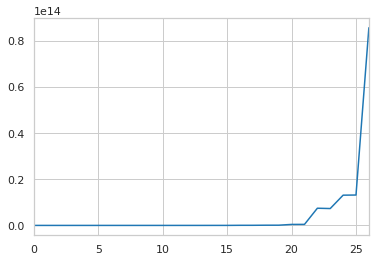

In [146]:
df2.creation_duration.plot()

https://networkx.github.io/documentation/stable/reference/algorithms/approximation.html

In [147]:
df2.to_csv("social_analysis_statistics.csv",index=False)

In [11]:
from networkx.algorithms import centrality
printLog("Computing graph properties...")
degreeCentralities=centrality.degree_centrality(returnedGraph)
inDegrees=centrality.in_degree_centrality(returnedGraph)
printLog("Done.")

[2019-03-04 15:12:35.226562]	Computing graph properties...
[2019-03-04 15:12:35.238867]	Done.


In [7]:
# very sloooooooow...
from networkx.algorithms import approximation
printLog("Computing graph properties...")
#s=approximation.max_clique(returnedGraph)
printLog("Done.")

[2019-03-04 15:09:25.855886]	Computing graph properties...
[2019-03-04 15:09:25.856747]	Done.
